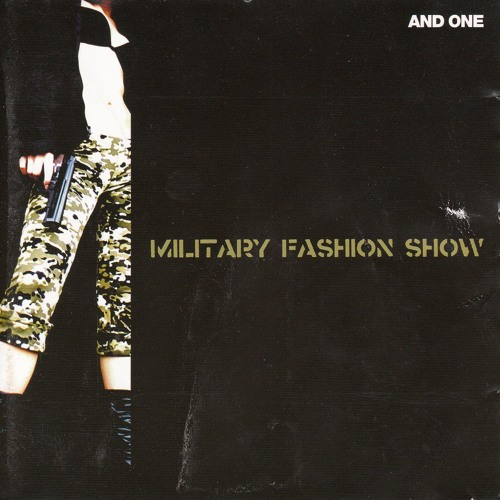

In [1]:
from IPython.display import Image

image = 'examples/sample.jpg'
Image(filename=image, width=400, height=400)

In [2]:
from crrptme.jpegcore import JPEGCore

jc = JPEGCore(image)

[CorruptMe] Downloading jpeg library from https://github.com/grigus-hub/crrpt-sandbox-wrapper/releases/download/latest/jpeg62.dll...
[CorruptMe] Cached at C:\Users\grigus\AppData\Local\Temp\corruptme_libs\jpeg62.dll
[CorruptMe] Downloading corruptjpeg library from https://github.com/grigus-hub/crrpt-sandbox-wrapper/releases/download/latest/corruptjpeg_latest.dll...
[CorruptMe] Cached at C:\Users\grigus\AppData\Local\Temp\corruptme_libs\corruptjpeg_latest.dll


In [3]:
import numpy as np
import PIL.Image as PILImage

def get_coeff_map(channel: int):
    if channel >= jc.num_components:
        raise ValueError(f"Channel {channel} out of range (max {jc.num_components-1})")

    bx_count = jc.get_num_blocks_x(channel)
    by_count = jc.get_num_blocks_y(channel)

    coeff_map = np.zeros((by_count * 8, bx_count * 8), dtype=np.float64)

    for by in range(by_count):
        for bx in range(bx_count):
            block = jc.get_dct_block(channel, bx, by)
            coeff_map[by*8:(by+1)*8, bx*8:(bx+1)*8] = block

    coeff_map = np.log(np.abs(coeff_map) + 1)
    coeff_map -= coeff_map.min()
    coeff_map /= coeff_map.max()
    coeff_map *= 255
    coeff_map = coeff_map.astype(np.uint8)

    coeff_map = np.array(
        PILImage.fromarray(coeff_map).resize((jc.width, jc.height), resample=PILImage.NEAREST)
    )

    return coeff_map

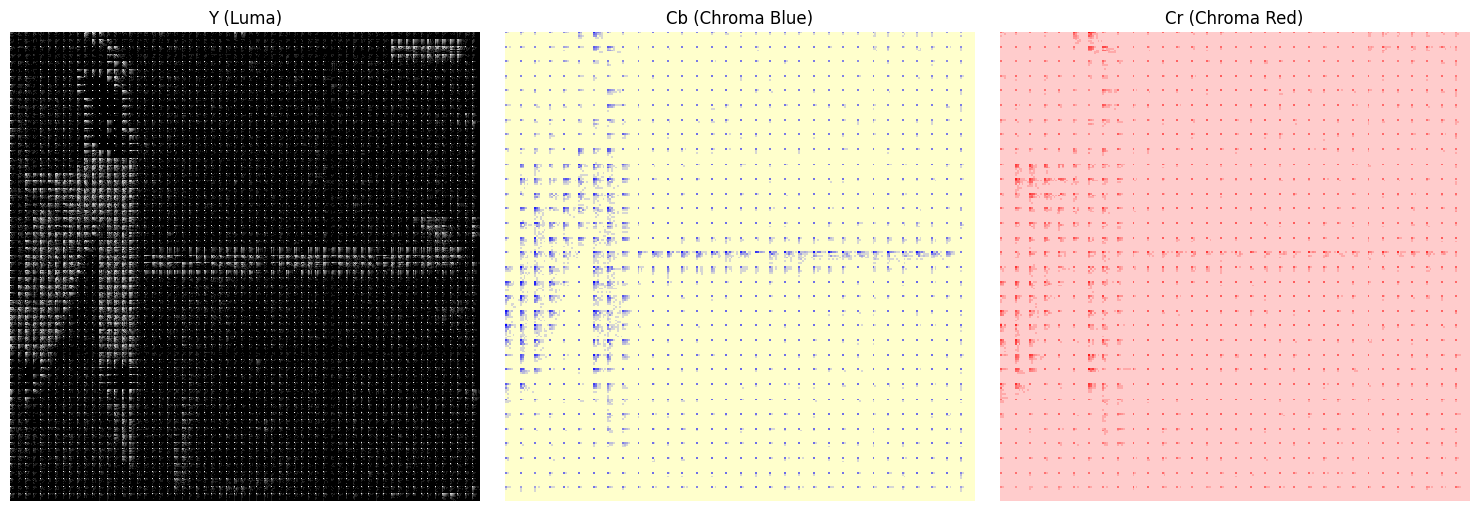

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cb_cmap = LinearSegmentedColormap.from_list("CbMap", ["#ffffcc", "#0000ff"])  # yellow → blue
cr_cmap = LinearSegmentedColormap.from_list("CrMap", ["#ffcccc", "#ff0000"])  # pink → red

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

channel_names = ["Y (Luma)", "Cb (Chroma Blue)", "Cr (Chroma Red)"]

for ch, ax in enumerate(axes):
    if ch < jc.num_components:
        coeff_map = get_coeff_map(ch)
        if ch == 0:
            ax.imshow(coeff_map, cmap="gray", interpolation="none")
        elif ch == 1:
            ax.imshow(coeff_map, cmap=cb_cmap, interpolation="none")
        elif ch == 2:
            ax.imshow(coeff_map, cmap=cr_cmap, interpolation="none")
        ax.set_title(channel_names[ch])
    else:
        ax.axis("off")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
from random import random

noise_strength = 5.0

for ch in range(jc.num_components):
    bx_count = jc.get_num_blocks_x(ch)
    by_count = jc.get_num_blocks_y(ch)

    for by in range(by_count):
        for bx in range(bx_count):
            block = jc.get_dct_block(ch, bx, by)
            if random() > 0.5:
                noise = np.random.normal(0, noise_strength, block.shape)
                noisy_block = block + noise

                jc.set_dct_block(ch, bx, by, noisy_block)

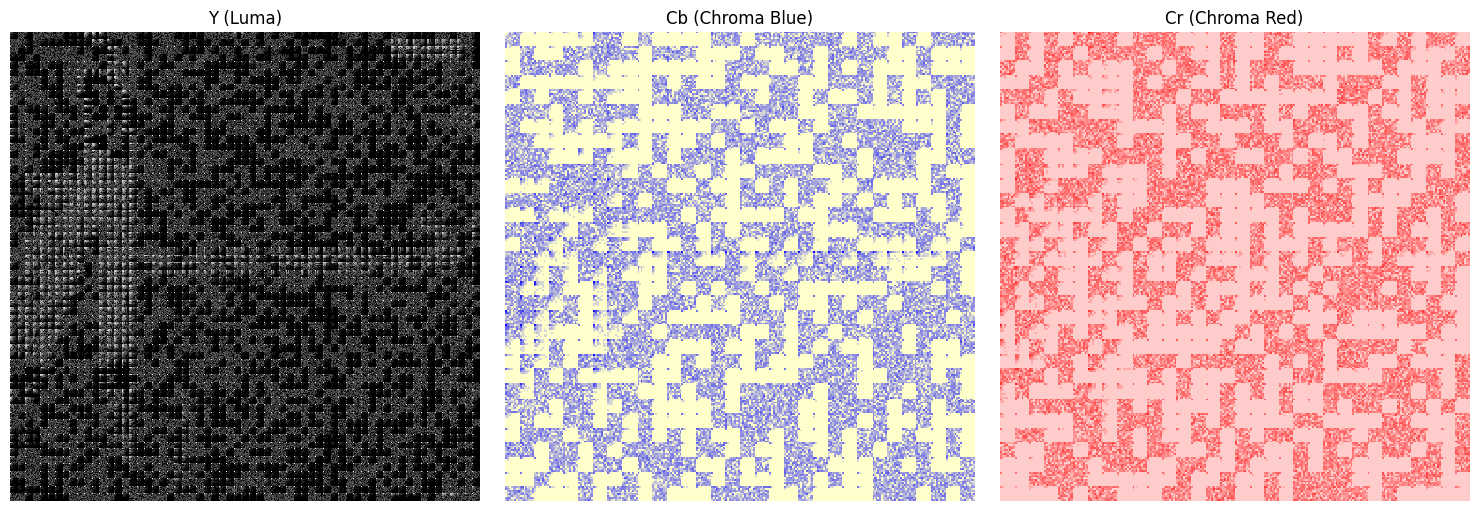

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

channel_names = ["Y (Luma)", "Cb (Chroma Blue)", "Cr (Chroma Red)"]

for ch, ax in enumerate(axes):
    if ch < jc.num_components:
        coeff_map = get_coeff_map(ch)
        if ch == 0:
            ax.imshow(coeff_map, cmap="gray", interpolation="none")
        elif ch == 1:
            ax.imshow(coeff_map, cmap=cb_cmap, interpolation="none")
        elif ch == 2:
            ax.imshow(coeff_map, cmap=cr_cmap, interpolation="none")
        ax.set_title(channel_names[ch])
    else:
        ax.axis("off")
    ax.axis("off")

plt.tight_layout()
plt.show()

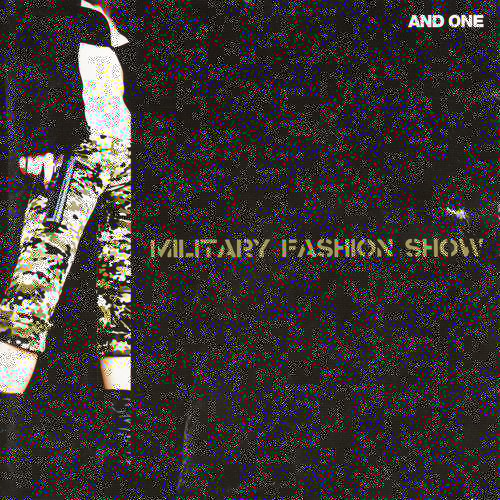

In [7]:
path = 'examples/sample_dct_noise.jpg'
jc.save(path, 10)
Image(filename=path, width=400, height=400)